In [ ]:
import stim
import sys
import os
sys.path.append(os.path.abspath("../src"))
from bb_ions import *


# [[30, 4, 5]] BB5 (weight-5 stabilisers) code from Ye Delfosse long chain [2503.22071] Table II
l = 5
m = 3
# A = x^0 + x
# B = x^0 + y + x^2*y^2
Aij = [(0, 0), (1, 0)]          # the powers (i, j) of each term x^i * y^j in A
Bij = [(0, 0), (0, 1), (2, 2)]
d = 5


## User-modifiable options for memory experiment circuit:

memory_basis = 'Z' 
num_syndrome_extraction_cycles = d
ps = [0.001, 0.002] # physical error rate values

## Make circuits: 

code = get_code_params(l, m, Aij, Bij, d)


# Clear last example circuits:
empty_folder('example_circuits')
empty_folder('example_circuit_diagrams')


# Generate circuits:
for p in ps:

    errors = default_errors(p)
    idle_during = default_idle_errors(p)

    circuit = make_circuit(  # (see src/bb_ions/circfuncs for explanation of make_circuit inputs)
        code,  
        memory_basis,  
        p,  
        num_syndrome_extraction_cycles,  
        errors,
        idle_during,
        sequential_gates = False, 
        exclude_opposite_basis_detectors = True,
        reuse_check_qubits = True,  
    )

    # Save circuit and diagram:
    filename = f"nkd=[[{code.n}_{code.k}_{code.d_max}]],p={p},b={memory_basis},r={num_syndrome_extraction_cycles},code=BB,l={l},m={m},A='{''.join(str(x) + str(y) for x, y in Aij)}',B='{''.join(str(x) + str(y) for x, y in Bij)}'"
    circuit.to_file(f"example_circuits/{filename}.stim")
    svg = str(circuit.diagram("timeline-svg"))
    with open(f"example_circuit_diagrams/{filename}.svg", "w", encoding="utf-8") as f: f.write(svg)

In [2]:
# # Run memory experiment simulations:

import sinter
import glob
from stimbposd import SinterDecoder_BPOSD, sinter_decoders

circuit_paths = glob.glob(f"example_circuits/nkd=[[{code.n}_{code.k}_{code.d_max}*.stim")

csv_path = "example_stats/collected_stats.csv"

tasks = [
    sinter.Task(
        circuit_path = path,
        json_metadata = sinter.comma_separated_key_values(path),
    )
    for path in circuit_paths
]


empty_folder('example_stats') # clear previous example stats

# Collect new stats:
samples = sinter.collect(
    num_workers=4,
    max_shots=10000,
    max_errors=1000,
    tasks = tasks,
    decoders=['bposd'],
    save_resume_filepath = csv_path,
    custom_decoders = sinter_decoders()
    )

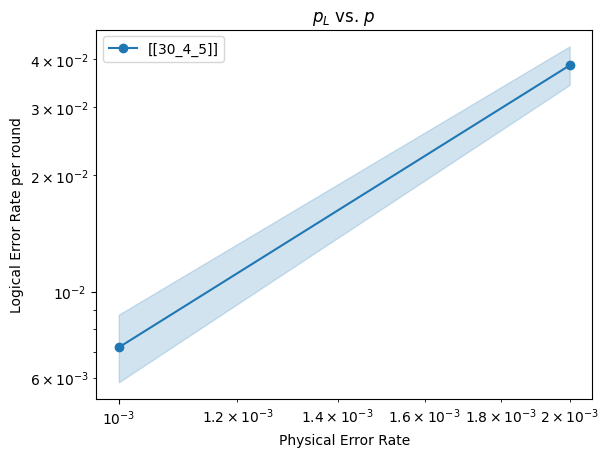

In [3]:
# Plot results:

import matplotlib.pyplot as plt

# Plot:
collected_stats = sinter.stats_from_csv_files(f'example_stats/collected_stats.csv')

fig, ax = plt.subplots(1, 1)

sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['nkd'],
    failure_units_per_shot_func = lambda stats: stats.json_metadata['r'], # set as num_rounds ('r') failure units to find pL per round
)

ax.loglog()
ax.legend()
ax.set_title("$p_L$ vs. $p$")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per round");

In [ ]:
# Other codes (copy and paste instead of [[30, 4, 5]] above)

# # [[144, 12, 12]] BB6 'gross' code from BB paper [2308.07915] Table III
# l = 12
# m = 6
# # A = x^3 + y + y^2
# # B = y^3 + x + x^2
# Aij = [(3, 0), (0, 1), (0, 2)]
# Bij = [(0, 3), (1, 0), (2, 0)]
# d = 12